##### Loading Imports & the Dataset

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [3]:
# Loading the csv data file to a Pandas DataFrame
dataset = pd.read_csv('/Users/ibrahimharoon/Documents/Uni/Year 3/Final Project/Stroke Prediction Tool/strokeDataset.csv')

##### Dataset Analysis

1. Finding the total rows and columns

In [4]:
# Finding the total rows and columns
dataset.shape

(5110, 12)

2. Identifying data types

In [5]:
# Printing the first 5 rows of the dataset
dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


3. Checking for missing values

In [6]:
# Checking if there are any missing values in each column
dataset.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

4. Checking for outliers in numerical columns

[Text(0.5, 1.0, 'Avg Glucose Level')]

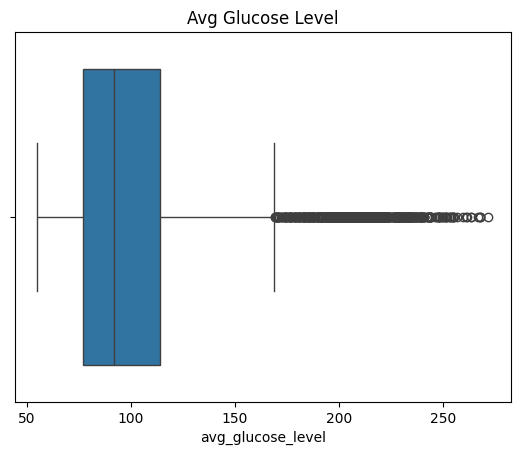

In [15]:
sns.boxplot(data=dataset['avg_glucose_level'], orient='h').set(title="Avg Glucose Level")

[Text(0.5, 1.0, 'BMI')]

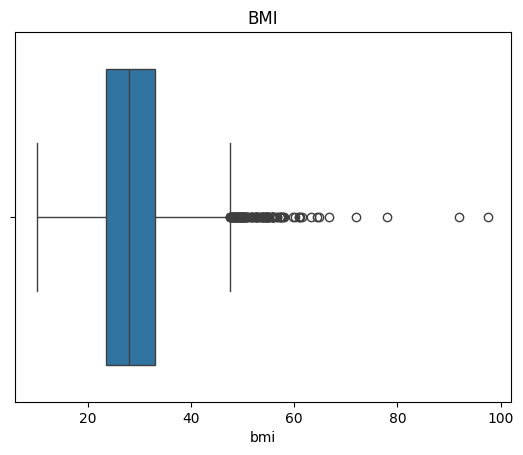

In [14]:
sns.boxplot(data=dataset['bmi'], orient='h').set(title="BMI")

4. Checking if the distribution of stroke is balanced

In [13]:
#'1' who had a stroke and '0' who did not have a stroke.
dataset['stroke'].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

##### Preprocessing

1. Creating a copy of the original dataset

In [ ]:
datasetCopy = dataset.copy()

2. Removing the id column

In [ ]:
dataset = dataset.drop('id', axis=1)

2. Encode columns without numerical values